%%HTML
<style>
    /* --- RESET DI BASE --- */
    .reveal .slides section {
        /* Forza la slide a occupare tutto lo spazio e ad allineare verticalmente */
        height: 100% !important;
        display: flex !important;
        flex-direction: column !important;
        justify-content: flex-start !important; /* Inizia dall'alto */
        align-items: center !important; /* Centra orizzontalmente */
        padding: 0 !important;
    }

    /* --- GESTIONE TITOLI --- */
    /* Riduciamo i margini dei titoli per lasciare spazio al grafico */
    .reveal h1, .reveal h2, .reveal h3 {
        margin-top: 20px !important;
        margin-bottom: 10px !important;
        flex-shrink: 0; /* Impedisce al titolo di schiacciarsi */
    }
    
    /* Il testo descrittivo sotto il titolo */
    .reveal p {
        margin: 0 0 10px 0 !important;
        flex-shrink: 0;
    }

    /* --- GESTIONE IMMAGINI/GRAFICI --- */
    /* Il contenitore del grafico */
    .jp-OutputArea-output, 
    .reveal div.output_subarea {
        flex-grow: 1; /* Occupa tutto lo spazio verticale rimanente */
        display: flex !important;
        align-items: center !important; /* Centra verticalmente nel suo spazio */
        justify-content: center !important;
        width: 100% !important;
        overflow: hidden !important; /* Niente barre di scorrimento */
        margin: 0 !important;
        padding: 0 !important;
    }

    /* L'immagine vera e propria */
    .jp-RenderedImage img, 
    .reveal div.output_subarea img {
        /* LE REGOLE D'ORO PER NON TAGLIARE MAI */
        width: auto !important;
        height: auto !important;
        
        /* Limiti massimi dinamici */
        max-width: 90% !important;  
        max-height: 65vh !important; /* Usa max il 65% dell'altezza schermo */
        
        /* Assicura che l'intera immagine sia visibile dentro i limiti */
        object-fit: contain !important; 
        
        background-color: white !important;
        border-radius: 6px !important;
        box-shadow: none !important;
    }

    /* Nascondi input e prompt */
    .jp-InputArea, .jp-OutputPrompt, .jp-Cell-inputWrapper {
        display: none !important;
    }
    /* Ma mostra il testo markdown */
    .jp-MarkdownCell .jp-InputArea, .jp-MarkdownCell .jp-Cell-inputWrapper {
        display: block !important;
    }
</style>

In [1]:
import pandas as pd
import os
from scipy.stats import pearsonr

def carica_dati(percorso_file):
    """Carica il csv e restituisce il DataFrame o None."""
    if os.path.exists(percorso_file):
        print(f"[INFO] Caricamento: {percorso_file}...")
        return pd.read_csv(percorso_file)
    else:
        print(f"[ERROR] File non trovato: {percorso_file}")
        return None

def pulisci_trasferimenti(df):
    """Pulisce i NaN e prepara i tipi di dato."""
    if df is None:
        raise ValueError("DataFrame vuoto passato a pulisci_trasferimenti")
    
    df_clean = df.copy()
    df_clean['transfer_fee'] = df_clean['transfer_fee'].fillna(0.0)
    df_clean['market_value_in_eur'] = df_clean['market_value_in_eur'].fillna(0.0)
    return df_clean

def calcola_metriche_annuali(df):
    """Aggrega i dati per stagione."""
    df_work = df.copy()
    
    # Gestione anno sicura
    try:
        df_work['Anno'] = df_work['transfer_season'].str.slice(0, 2).astype(int) + 2000
    except Exception:
        df_work['Anno'] = pd.to_numeric(df_work['transfer_season'].str.slice(0, 2), errors='coerce') + 2000
        
    df_filt = df_work[df_work['Anno'].between(2010, 2023)].dropna(subset=['Anno']).copy()
    
    df_agg = df_filt.groupby('transfer_season').agg(
        Valore_Totale_EURO=('market_value_in_eur','sum'),
        Spesa_Totale_EUR=('transfer_fee', 'sum'),
        Volume_Trasferimenti=('player_id', 'count')
    ).reset_index()

    df_agg.rename(columns={'transfer_season': 'Anno-Calcistico'}, inplace=True)
    df_agg['Spesa_Mld_EUR'] = df_agg['Spesa_Totale_EUR'] / 1e9
    df_agg['Valore_Totale_Mld_EURO'] = df_agg['Valore_Totale_EURO'] / 1e9
    
    return df_agg

def aggiungi_spesa_reale(df_agg):
    """Calcola l'inflazione interna del mercato."""
    df = df_agg.copy()
    spesa_euro = df['Spesa_Mld_EUR'] * 1e9
    df['Costo_Medio_Unitario'] = spesa_euro / df['Volume_Trasferimenti']
    
    # Anno base: ultima entry
    costo_base = df.iloc[-1]['Costo_Medio_Unitario']
    df['Spesa_Reale_Mld_EUR'] = df['Spesa_Mld_EUR'] * (costo_base / df['Costo_Medio_Unitario'])
    return df

def analizza_efficienza(df_raw, stagioni_target):
    """Analisi avanzata efficienza mercato (delta valore/prezzo)."""
    df = df_raw[df_raw['transfer_season'].isin(stagioni_target)].copy()
    df = df[df['transfer_fee'] > 0] # Solo onerosi
    
    df_agg = df.groupby('transfer_season').agg(
        Valore_Totale_EURO=('market_value_in_eur', 'sum'),
        Spesa_Totale_EUR=('transfer_fee', 'sum')
    ).reset_index()
    
    df_agg.rename(columns={'transfer_season': 'Anno-Calcistico'}, inplace=True)
    df_agg['Spesa_Mld_EUR'] = df_agg['Spesa_Totale_EUR'] / 1e9
    df_agg['Valore_Totale_Mld_EURO'] = df_agg['Valore_Totale_EURO'] / 1e9
    
    df_agg['Delta_Assoluto'] = df_agg['Spesa_Mld_EUR'] - df_agg['Valore_Totale_Mld_EURO']
    df_agg['Premium_Percentuale'] = (df_agg['Delta_Assoluto'] / df_agg['Valore_Totale_Mld_EURO']) * 100
    
    # Sorting logico
    df_agg['Anno-Calcistico'] = pd.Categorical(df_agg['Anno-Calcistico'], categories=stagioni_target, ordered=True)
    return df_agg.sort_values('Anno-Calcistico')

def calcola_correlazione(df, col_x, col_y):
    """Calcolo coefficiente di Pearson e P-value"""
    return pearsonr(df[col_x], df[col_y])


def focusVerde(df_efficienza_full):
    stagioni_focus = ['20/21', '21/22', '22/23'] 
    df_focus = df_efficienza_full[df_efficienza_full['Anno-Calcistico'].isin(stagioni_focus)].copy()
    df_focus['Anno-Calcistico'] = pd.Categorical(
        df_focus['Anno-Calcistico'], 
        categories=stagioni_focus, 
        ordered=True
    )
    return df_focus.sort_values('Anno-Calcistico')
#==== FINE FILE ===#

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd
import numpy as np

# Configurazione stile globale
sns.set_theme(style="darkgrid")

def salva_e_mostra(fig, path_completo):
    """Funzione helper per salvare e mostrare."""
    try:
        # tight_layout spesso aiuta a non tagliare etichette
        plt.tight_layout()
        fig.savefig(path_completo)
        # print(f"[GRAFICO] Salvato in: {path_completo}")
        plt.show()
    except Exception as e:
        print(f"[ERROR] Impossibile salvare il grafico: {e}")

def plot_confronto_nominale_reale(df, cartella_output):
    """
    Funzione:
    - confronto tra spesa reale e spesa inflazionata
    - Area rossa di riempimento (inflazione)
    """
    plt.figure(figsize=(12, 7))
    
    # Linea 1: Spesa Nominale
    sns.lineplot(
        data=df, 
        x='Anno-Calcistico', 
        y='Spesa_Mld_EUR', 
        label='Spesa Nominale (Cifre Ufficiali)', 
        marker='o', color='gray', linestyle='--', alpha=0.6, linewidth=2
    )

    # Linea 2: Spesa Reale
    sns.lineplot(
        data=df, 
        x='Anno-Calcistico', 
        y='Spesa_Reale_Mld_EUR', 
        label='Spesa Reale (Al netto inflazione mercato)', 
        marker='o', color='#ff3333', linewidth=3
    )

    # Area tra le due curve
    plt.fill_between(
        df['Anno-Calcistico'], 
        df['Spesa_Mld_EUR'], 
        df['Spesa_Reale_Mld_EUR'], 
        color='red', alpha=0.1
    )

    #plt.title("L'Illusione della Spesa: Nominale vs Reale (Base 2024)", fontsize=16, fontweight='bold', color='#333')
    plt.ylabel("Miliardi di € (Valuta 2024)", fontsize=12)
    plt.xlabel("Stagione", fontsize=12)
    plt.xticks(rotation=45)
    plt.legend()
    
    salva_e_mostra(plt, os.path.join(cartella_output, 'confronto_spesa_nominale_reale.png'))

def plot_scatter_volume_spesa(df, r, p, cartella_output):
    """
    Funzione:
    - scatterplot correlazione volume trasferimenti - costo annuale
    - identifico valori sfasati e li cerchio
    """
    colonna_x = 'Volume_Trasferimenti'
    colonna_y = 'Spesa_Mld_EUR'
    colonna_label = 'Anno-Calcistico'

    plt.figure(figsize=(12, 7))
    sns.set_style("whitegrid")

    # 1. DISEGNA TUTTO (Base visibile)
    sns.regplot(
        data=df,
        x=colonna_x,
        y=colonna_y,
        scatter_kws={'s': 200, 'alpha': 0.9, 'edgecolor': 'white', 'linewidths': 1.5, 'color': '#2c7bb6'}, 
        line_kws={'color': '#d62728', 'linestyle': '--', 'linewidth': 2.5 }# , #'label': f'Trend Lineare ($R={r:.2f}$)'}
    )

    # 2. EVIDENZIAZIONE SELETTIVA E ETICHETTE
    anni_covid = ['20/21', '21/22']
    
    # Calcolo offset dinamico basato sul range dei dati
    y_range = df[colonna_y].max() - df[colonna_y].min()
    offset = y_range * 0.035 

    for i in range(df.shape[0]):
        anno = df[colonna_label].iloc[i]
        x_val = df[colonna_x].iloc[i]
        y_val = df[colonna_y].iloc[i]
        
        if anno in anni_covid:
            # --- SOLO CERCHIO ROSSO ---
            plt.scatter([x_val], [y_val], s=350, facecolors='none', edgecolors='red', linewidths=3.5, zorder=10)
            # Etichetta Rossa
            plt.text(x_val, y_val - (offset), "", color='#d62728', fontweight='bold', fontsize=12, ha='center', va='top', zorder=11)
        else:
            # --- NORMALITÀ ---
            plt.text(x_val, y_val - offset, "", color='black', fontsize=10, fontweight='bold', ha='center', va='top', alpha=0.8)

    # Box statistiche
    #stats_text = f"Pearson $r$: {r:.3f}\n$p$-value: {p:.3f}"
    #plt.text(0.02, 0.95, stats_text, transform=plt.gca().transAxes, fontsize=11,
    #         bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.95, edgecolor='#cccccc'))

    #plt.title('Correlazione Volume vs Spesa', fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Volume Trasferimenti (Numero Acquisti)', fontsize=13)
    plt.ylabel('Spesa Totale (Miliardi €)', fontsize=13)
    #plt.legend(loc='lower right', frameon=True, fontsize=12, facecolor='white', framealpha=1)
    
    salva_e_mostra(plt, os.path.join(cartella_output, 'scatterplot_finale_clean.png'))

def plot_istogramma_spese(df, cartella_output):
    """
    Funzione:
        - istogramma spese annuali: agglomerato spese (considerati tutti i trasferimenti)
    """
    anni = df['Anno-Calcistico']
    spese = df['Spesa_Mld_EUR']

    plt.figure(figsize=(12, 7)) 
    bars = plt.bar(anni, spese, color='skyblue', label='Spesa (Mld EUR)')

    plt.xlabel('Stagione Calcistica', fontsize=12)
    plt.ylabel('Spesa (Miliardi EUR)', fontsize=12)
    #plt.title('Spesa Annuale per Trasferimenti Calcistici', fontsize=14, fontweight='bold')
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Etichette sopra le barre
    for bar in bars:
        yval = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2.0,
            yval + (spese.max() * 0.01),
            "",
            ha='center', va='bottom', fontsize=9
        )

    salva_e_mostra(plt, os.path.join(cartella_output, 'spese_annuali_istogramma.png'))

def plot_trend_efficienza(df_plot, cartella_output):
    """
    Ripristinato:
    - Doppia fill_between (Rosso per overspending, Verde per underspending)
    - Colori specifici e stili di linea
    """
    plt.figure(figsize=(14, 7))
    
    # Linea Spesa
    sns.lineplot(data=df_plot, x='Anno-Calcistico', y='Spesa_Mld_EUR', 
                 marker='o', label='Spesa Effettiva (Prezzo)', color='#E63946', linewidth=3)
    
    # Linea Valore
    sns.lineplot(data=df_plot, x='Anno-Calcistico', y='Valore_Totale_Mld_EURO', 
                 marker='o', label='Valore Stimato (Fair Value)', color='#1D3557', linestyle='--', linewidth=3)
    
    # RIEMPIMENTO AREE (Fondamentale per vedere l'efficienza)
    plt.fill_between(df_plot['Anno-Calcistico'], 
                     df_plot['Valore_Totale_Mld_EURO'], 
                     df_plot['Spesa_Mld_EUR'], 
                     where=(df_plot['Spesa_Mld_EUR'] > df_plot['Valore_Totale_Mld_EURO']),
                     interpolate=True, color='#E63946', alpha=0.15, label='Overspending (Inefficienza)')
    
    plt.fill_between(df_plot['Anno-Calcistico'], 
                     df_plot['Valore_Totale_Mld_EURO'], 
                     df_plot['Spesa_Mld_EUR'], 
                     where=(df_plot['Spesa_Mld_EUR'] <= df_plot['Valore_Totale_Mld_EURO']),
                     interpolate=True, color='#2A9D8F', alpha=0.15, label='Underspending (Risparmio)')

    #plt.title("Prezzo Pagato vs Valore Stimato: L'Evoluzione della Bolla", fontsize=16, fontweight='bold', pad=20)
    plt.ylabel("Miliardi di €", fontsize=12, fontweight='bold')
    plt.xlabel("Stagione", fontsize=12, fontweight='bold')
    plt.grid(True, alpha=0.3, linestyle='--')
    plt.legend(fontsize=11, loc='upper left', frameon=True, framealpha=0.9)
    plt.xticks(rotation=45)
    
    salva_e_mostra(plt, os.path.join(cartella_output, 'trend_spesa_valore.png'))

def plot_premium_percentuale(df_plot, cartella_output):
    """
    Ripristinato:
    - Logica semaforica dei colori (Rosso scuro, Arancio, Verde)
    - Posizionamento offset del testo sopra/sotto lo zero
    """
    media_premium = df_plot['Premium_Percentuale'].mean()
    
    plt.figure(figsize=(14, 7))
    
    # Logica colori
    colors = []
    for val in df_plot['Premium_Percentuale']:
        if val >= 25: colors.append('#D62828')    # Rosso Scuro
        elif val > 0: colors.append('#F77F00')    # Arancione
        else:         colors.append('#2A9D8F')    # Verde

    sns.barplot(data=df_plot, x='Anno-Calcistico', y='Premium_Percentuale', 
                hue='Anno-Calcistico', palette=colors, legend=False)
    
    plt.axhline(0, color='black', linewidth=1.5, linestyle='-')
    
    # Etichette sui valori con offset condizionale
    for i, v in enumerate(df_plot['Premium_Percentuale']):
        offset = 1.5 if v >= 0 else -3.5
        txt_color = 'black' 
        plt.text(i, v + offset, f"{v:.1f}%", ha='center', va='center', fontweight='bold', fontsize=11, color=txt_color)

    #plt.title("Il 'Premium' di Mercato: Quanto si paga in più rispetto al valore reale?", fontsize=16, fontweight='bold', pad=20)
    plt.ylabel("% Sovrapprezzo / Sottoprezzo", fontsize=12, fontweight='bold')
    plt.xlabel("Stagione", fontsize=12, fontweight='bold')
    plt.xticks(rotation=45)
    
    plt.axhline(media_premium, color='gray', linestyle='--', alpha=0.7, label=f'Media Periodo: {media_premium:.1f}%')
    plt.legend(loc='upper right')

    salva_e_mostra(plt, os.path.join(cartella_output, 'percentuali_differenza.png'))

# --- AGGIUNGI QUESTA FUNZIONE ALLA FINE DI grafici.py ---
def plot_focus_covid(df_focus, cartella_output):
    """
    Grafico "Microscopio": Zoom estremo con barra di connessione visiva (pulita).
    Rimosse annotazioni testuali per massima chiarezza.
    """
    df_plot = df_focus.sort_values('Anno-Calcistico').copy()

    plt.figure(figsize=(10, 7))

    # --- CALCOLO LIMITI ASSE Y (Zoom Aggressivo) ---
    all_values = pd.concat([df_plot['Spesa_Mld_EUR'], df_plot['Valore_Totale_Mld_EURO']])
    y_min = all_values.min()
    y_max = all_values.max()
    
    # Margine ridotto (2%)
    margin = (y_max - y_min) * 0.02 
    plt.ylim(y_min - margin, y_max + margin)

    # --- LINEE ---
    sns.lineplot(data=df_plot, x='Anno-Calcistico', y='Spesa_Mld_EUR', 
                 marker='o', markersize=9, 
                 label='Spesa Effettiva', color='#E63946', linewidth=3, zorder=3)
    
    sns.lineplot(data=df_plot, x='Anno-Calcistico', y='Valore_Totale_Mld_EURO', 
                 marker='D', markersize=7, 
                 label='Valore Stimato', color='#1D3557', linestyle='--', linewidth=2.5, zorder=2)

    # --- RIEMPIMENTO AREE ---
    # Area Rossa
    plt.fill_between(df_plot['Anno-Calcistico'], 
                     df_plot['Valore_Totale_Mld_EURO'], 
                     df_plot['Spesa_Mld_EUR'], 
                     where=(df_plot['Spesa_Mld_EUR'] > df_plot['Valore_Totale_Mld_EURO']),
                     interpolate=True, color='#E63946', alpha=0.15)
    
    # Area VERDE
    plt.fill_between(df_plot['Anno-Calcistico'], 
                     df_plot['Valore_Totale_Mld_EURO'], 
                     df_plot['Spesa_Mld_EUR'], 
                     where=(df_plot['Spesa_Mld_EUR'] <= df_plot['Valore_Totale_Mld_EURO']),
                     interpolate=True, color='#2A9D8F', alpha=0.3, hatch='//')

    # --- BARRA DI CONNESSIONE (SOLO VISIVA) ---
    target_season = '21/22'
    try:
        row_target = df_plot[df_plot['Anno-Calcistico'] == target_season].iloc[0]
        spesa_target = row_target['Spesa_Mld_EUR']
        valore_target = row_target['Valore_Totale_Mld_EURO']
        gap = spesa_target - valore_target

        # Disegniamo la barra solo se c'è un gap visibile, colorandola in base al segno
        if gap < 0:
            colore_barra = '#2A9D8F' # Verde (Underspending)
            label_barra = 'Gap (Risparmio)'
        else:
            colore_barra = '#E63946' # Rosso (Overspending)
            label_barra = 'Gap (Spreco)'

        # Linea verticale pulita senza testo
        plt.vlines(x=target_season, ymin=spesa_target, ymax=valore_target, 
                   colors=colore_barra, linewidth=4, label=label_barra, zorder=4)
                     
    except IndexError:
        pass

    #plt.title("MICRO-ANALISI: 21/22 Stagione di Correzione", fontsize=14, fontweight='bold', pad=15)
    plt.ylabel("Miliardi di € (Zoom Max)", fontsize=11, fontweight='bold')
    plt.grid(True, alpha=0.4, linestyle='--')
    plt.legend(loc='upper left')
    
    salva_e_mostra(plt, os.path.join(cartella_output, 'focus_trend_covid.png'))

def focus_AreaVerde(df_focus, cartella_output):
    """
    Grafico "Pura Geometria": 
    - No marker, No testo interno, No barre verticali.
    - SÌ Legenda esplicita per l'area verde.
    """
    df_plot = df_focus.sort_values('Anno-Calcistico').copy()

    plt.figure(figsize=(8, 8))

    # --- SETUP ZOOM CHIRURGICO SUL 21/22 ---
    try:
        row_2122 = df_plot[df_plot['Anno-Calcistico'] == '21/22'].iloc[0]
        val_spesa = row_2122['Spesa_Mld_EUR']
        val_valore = row_2122['Valore_Totale_Mld_EURO']
        
        mid_point = (val_spesa + val_valore) / 2
        # Zoom 50x
        plt.ylim(mid_point - 0.15, mid_point + 0.15)
        
    except IndexError:
        print("[ERR] Dati 21/22 non trovati per lo zoom.")
        return

    # --- DISEGNO LINEE PURE ---
    sns.lineplot(data=df_plot, x='Anno-Calcistico', y='Spesa_Mld_EUR', 
                 marker=None, 
                 label='Spesa (Prezzo)', color='#E63946', linewidth=4, zorder=3)
    
    sns.lineplot(data=df_plot, x='Anno-Calcistico', y='Valore_Totale_Mld_EURO', 
                 marker=None,
                 label='Valore (Fair Value)', color='#1D3557', linestyle='--', linewidth=3, zorder=2)

    # --- AREA VERDE (Con ETICHETTA per la Legenda) ---
    plt.fill_between(df_plot['Anno-Calcistico'], 
                     df_plot['Valore_Totale_Mld_EURO'], 
                     df_plot['Spesa_Mld_EUR'], 
                     where=(df_plot['Spesa_Mld_EUR'] <= df_plot['Valore_Totale_Mld_EURO']),
                     interpolate=True, 
                     color='#2A9D8F', 
                     alpha=0.6, 
                     hatch='////',
                     label='Area di Risparmio (Underspending)') # <--- QUI STA LA MODIFICA

    # Riempimento rosso (Senza etichetta per non affollare, o aggiungila se vuoi)
    plt.fill_between(df_plot['Anno-Calcistico'], 
                     df_plot['Valore_Totale_Mld_EURO'], 
                     df_plot['Spesa_Mld_EUR'], 
                     where=(df_plot['Spesa_Mld_EUR'] > df_plot['Valore_Totale_Mld_EURO']),
                     interpolate=True, color='#E63946', alpha=0.1)

    #plt.title("Focus 'Pura Geometria' 21/22", fontsize=14, fontweight='bold', pad=15)
    plt.ylabel("Miliardi di € (Ultra-Zoom)", fontsize=11)
    plt.grid(True, alpha=0.3, linestyle='--')
    
    # La legenda ora includerà automaticamente l'area verde grazie al parametro 'label' sopra
    plt.legend(loc='upper left', frameon=True, framealpha=0.95)

    salva_e_mostra(plt, os.path.join(cartella_output, 'focus_area_verde_pure.png'))

#==== FINE FILE ===#

In [3]:
import os
import sys
import pandas as pd
# Importiamo i nostri moduli personalizzati

# --- CONFIGURAZIONE ---
BASE_DIR = os.getcwd()
CART_DATI = os.path.join(BASE_DIR, "..", "Dataset")
CART_GRAFICI = os.path.join(BASE_DIR, "..", "Grafici")
FILE_INPUT = os.path.join(CART_DATI, "transfers.csv")

STAGIONI_TARGET = [
    '10/11', '11/12', '12/13', '13/14', '14/15', '15/16', 
    '16/17', '17/18', '18/19', '19/20', '20/21', '21/22', 
    '22/23', '23/24'
]

if not os.path.exists(CART_GRAFICI):
    os.makedirs(CART_GRAFICI)
    print(f"[SETUP] Creata cartella grafici: {CART_GRAFICI}")

df_raw = carica_dati(FILE_INPUT)
if df_raw is None:
    sys.exit("Impossibile procedere senza dati.")
    

df_clean = pulisci_trasferimenti(df_raw)

# 3. ELABORAZIONE METRICHE GENERALI
print("--- Elaborazione Metriche Annuali ---")
df_annuale = calcola_metriche_annuali(df_clean)
df_annuale = aggiungi_spesa_reale(df_annuale)

# Calcolo Statistiche
r_pearson, p_value = calcola_correlazione(df_annuale, 'Spesa_Mld_EUR', 'Volume_Trasferimenti')
print(f"[RISULTATI] Correlazione Volume/Spesa -> r: {r_pearson:.2f}, p: {p_value:.4f}")

# 4. ELABORAZIONE EFFICIENZA (PREZZO VS VALORE)
print("--- Elaborazione Efficienza Mercato ---")
# Calcolo su tutto il periodo storico
df_efficienza_full = analizza_efficienza(df_clean, STAGIONI_TARGET)

# === NUOVO STEP: PREPARAZIONE DATI PER IL FOCUS COVID ===
print("--- Preparazione Focus COVID ---")
stagioni_focus = ['18/19', '19/20', '20/21', '21/22', '22/23'] # Finestra 5 anni

# Filtriamo il dataframe completo tenendo solo le righe che sono "isin" (dentro) la nostra lista target
df_focus = df_efficienza_full[df_efficienza_full['Anno-Calcistico'].isin(stagioni_focus)].copy()

# Importante: Ridefiniamo l'ordine categorico solo per queste 5 stagioni
# Altrimenti il grafico potrebbe lasciare spazi vuoti per gli anni mancanti
df_focus['Anno-Calcistico'] = pd.Categorical(
    df_focus['Anno-Calcistico'], 
    categories=stagioni_focus, 
    ordered=True
)
df_focus = df_focus.sort_values('Anno-Calcistico')


#==== FINE FILE ===#

[INFO] Caricamento: C:\Users\Andrea\Desktop\Anatomia-di-un-trasferimento---Progetto-Data-Science\Notebook\..\Dataset\transfers.csv...
--- Elaborazione Metriche Annuali ---
[RISULTATI] Correlazione Volume/Spesa -> r: 0.95, p: 0.0000
--- Elaborazione Efficienza Mercato ---
--- Preparazione Focus COVID ---


<div style="text-align: left; margin-top: 40px;">
    <h1 style="color: #2c3e50; font-size: 65px; margin-bottom: 10px; line-height: 1.2;">
        <strong>Anatomia di un Trasferimento</strong>
    </h1>
    <h3 style="color: #7f8c8d; font-weight: normal; margin-top: 0; margin-bottom: 40px;">
        Analisi economica e statistica del calciomercato
    </h3>
    <hr style="border: 0; height: 3px; background-color: #3498db; width: 100%; margin-bottom: 40px;">
    <div style="font-size: 28px; color: #34495e;">
        <p style="margin: 10px 0;">
            <strong>Candidato:</strong> Andrea Gioia
        </p>
        <p style="margin: 10px 0;">
            <strong>Matricola:</strong> 169484
        </p>
    </div>
</div>

<div style="text-align: left; margin-top: 20px;">
    <h2 style="color: #2c3e50; font-size: 50px; margin-bottom: 30px; border-bottom: 3px solid #3498db; padding-bottom: 15px;">
        Introduzione e Obiettivi della Ricerca
    </h2>
    <div style="font-size: 30px; color: #34495e; line-height: 1.4;">
        <div style="margin-bottom: 40px;">
            <strong style="color: #2980b9; display: block; margin-bottom: 10px;">Motivazione del Progetto:</strong>
            Valutare sotto un punto di vista economico il calcio attraverso il suo mercato.
        </div>
        <div>
            <strong style="color: #2980b9; display: block; margin-bottom: 15px;">Domande di Ricerca:</strong>
            <ol style="margin-left: 40px;">
                <li style="margin-bottom: 20px;">
                    <strong>Analisi del Trend:</strong> qual è l'andamento dei costi dei trasferimenti? E considerando la componente inflattiva?
                </li>
                <li>
                    <strong>Impatto con uno shock:</strong> in che modo il mercato reagisce agli shock della vita esterna?
                </li>
            </ol>
        </div>
    </div>
</div>

<div style="text-align: left; margin-top: 20px;">
    <h2 style="color: #2c3e50; font-size: 50px; margin-bottom: 30px; border-bottom: 3px solid #3498db; padding-bottom: 15px;">
        Descrizione del Dataset
    </h2>
    <div style="font-size: 28px; color: #34495e; line-height: 1.5;">
        <div style="margin-bottom: 30px;">
            <strong style="color: #2980b9; font-size: 32px;">Fonte e Origine:</strong>
            <ul style="margin-top: 10px; margin-left: 40px;">
                <li><strong>Dataset:</strong> Dati estratti dal portale <em>Transfermarkt</em>.</li>
                <li><strong>Copertura Temporale:</strong> Stagioni dal 2010/2011 al 2023/2024.</li>
                <li><strong>Disponibilità:</strong> <a href="https://www.kaggle.com/datasets/davidcariboo/player-scores/data" target="_blank" style="color: #e67e22; text-decoration: underline;">Dataset Kaggle consultabile qui</a></li>
            </ul>
        </div>
        <div style="margin-bottom: 30px;">
            <strong style="color: #2980b9; font-size: 32px;">Contenuto dei Dati:</strong>
            <p style="margin: 5px 0;">Il dataset include variabili quantitative e categoriche per ogni trasferimento:</p>
            <ul style="margin-left: 40px;">
                <li><em>Transfer Fee</em> (Costo del cartellino).</li>
                <li><em>Market Value</em> (Valore stimato).</li>
                <li><em>Stagione</em> e <em>Dati Anagrafici</em> (Età, Ruolo, Nazionalità).</li>
            </ul>
        </div>
        <div style="background-color: #fdf2e9; padding: 15px; border-left: 5px solid #e67e22; border-radius: 5px;">
            <strong style="color: #d35400; font-size: 32px;">Limiti dello Studio:</strong>
            <ul style="margin-top: 10px; margin-left: 40px;">
                <li><strong>Ingaggi (Wages):</strong> Manca il costo degli stipendi (cifre significative).</li>
                <li><strong>Commissioni:</strong> Esclusi costi accessori (agenti, premi), quindi la spesa è una stima al ribasso.</li>
            </ul>
        </div>
    </div>
</div>

<div style="text-align: center; width: 100%;">
    <h2 style="color: #2c3e50; margin-bottom: 10px;">1. La Visione d'Insieme</h2>
    <p style="font-size: 28px; color: #34495e; margin: 0;">
        Crescita apparente con un picco storico di <strong>8.52 Miliardi €</strong> nel 23/24.
    </p>
</div>

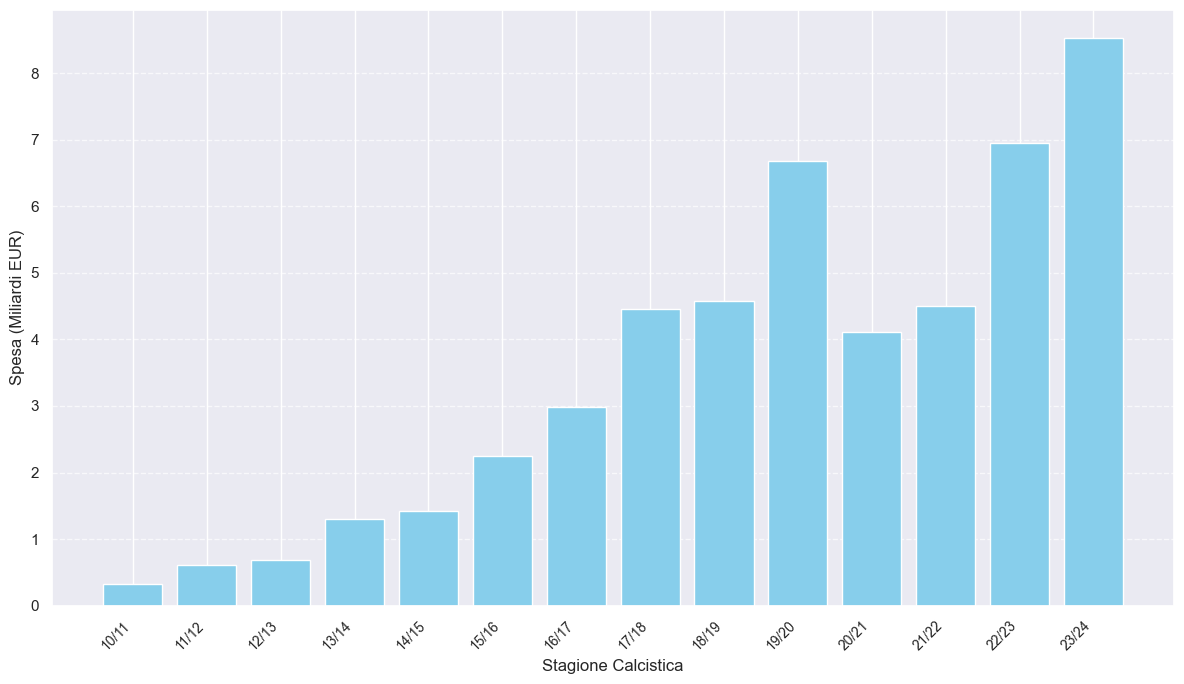

In [4]:
plot_istogramma_spese(df_annuale, CART_GRAFICI)


<div style="text-align: center; width: 100%;">
    <h2 style="color: #2c3e50; margin-bottom: 10px;">2. La Realtà: L'Inflazione del Talento</h2>
    <p style="font-size: 28px; color: #34495e; margin: 0;">
        Normalizzando i costi, la spesa reale è <strong>stagnante dal 2017</strong>.
    </p>
</div>

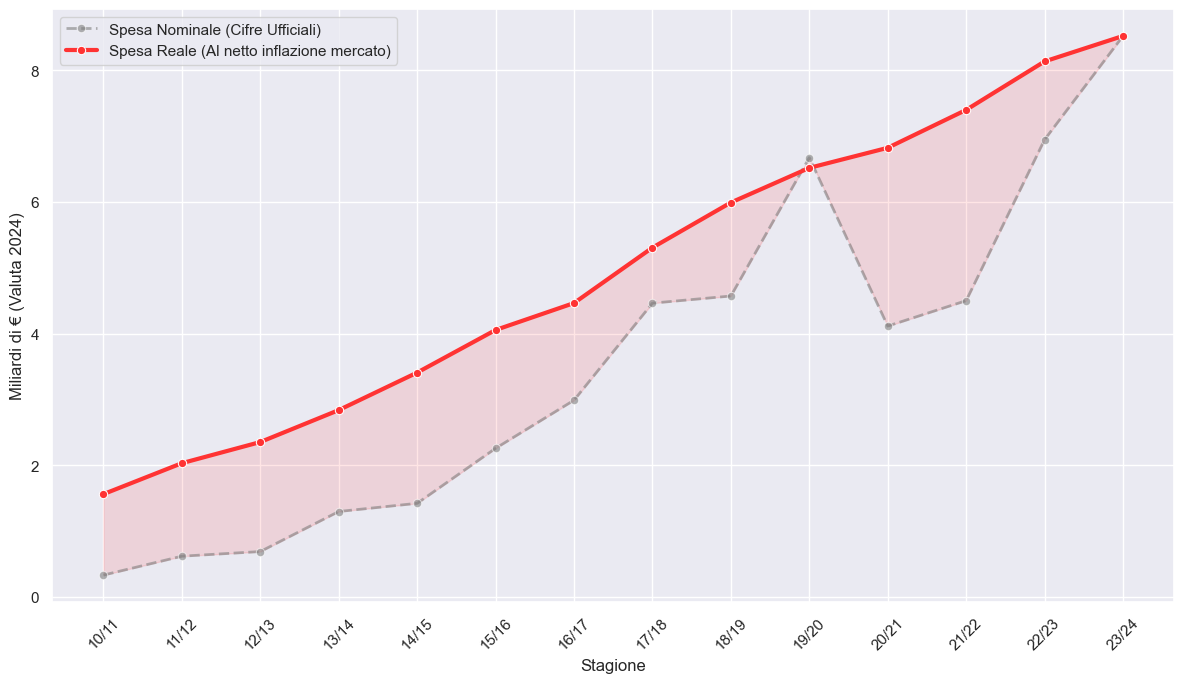

In [5]:
#print("[GRAFICO]: Confronto valori reali e valore ipotetico inflazione")
plot_confronto_nominale_reale(df_annuale, CART_GRAFICI)


<div style="text-align: center; width: 100%;">
    <h2 style="color: #2c3e50; margin-bottom: 10px;">3. La Struttura del Mercato</h2>
    <p style="font-size: 28px; color: #34495e; margin: 0;">
        Forte correlazione (<strong>R=0.95</strong>) tra volume e spesa, eccetto negli anni COVID.
    </p>
</div>

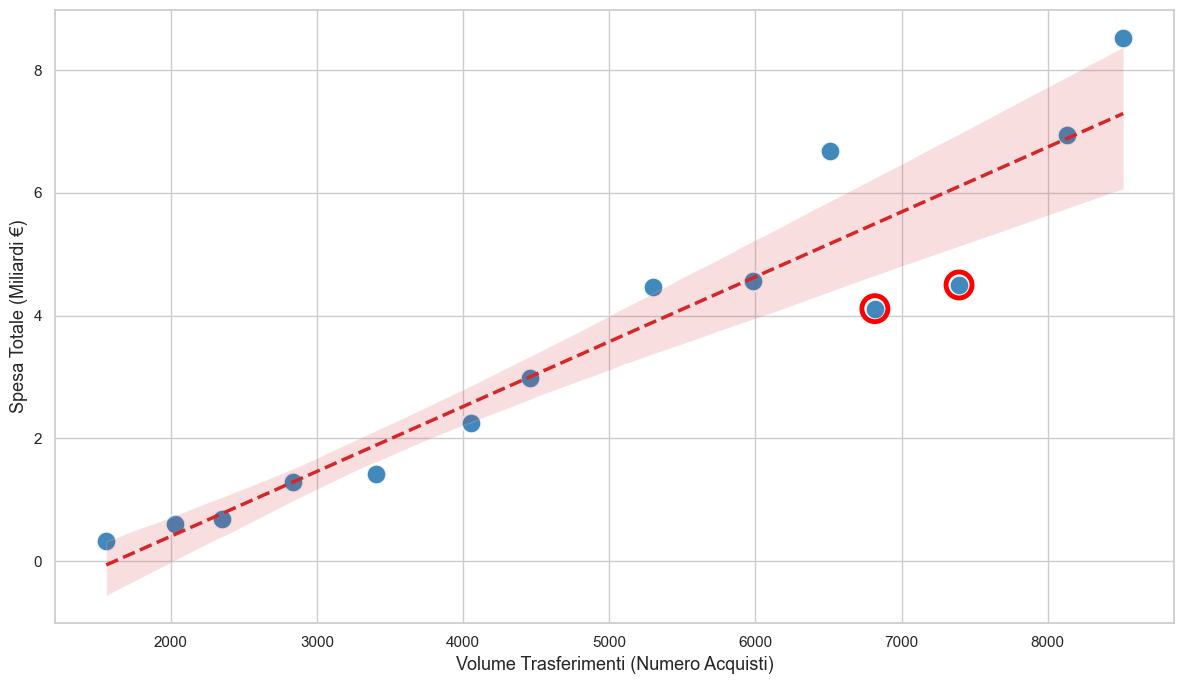

In [6]:
#print("[GRAFICO]: Grafico correlazione volume - spesa")
plot_scatter_volume_spesa(df_annuale, r_pearson, p_value, CART_GRAFICI)


<div style="text-align: center; width: 100%;">
    <h2 style="color: #2c3e50; margin-bottom: 10px;">4. L'Inefficienza Strutturale</h2>
    <p style="font-size: 28px; color: #34495e; margin: 0;">
        La spesa effettiva (Rosso) supera sistematicamente il <strong>Fair Value</strong> (Blu).
    </p>
</div>

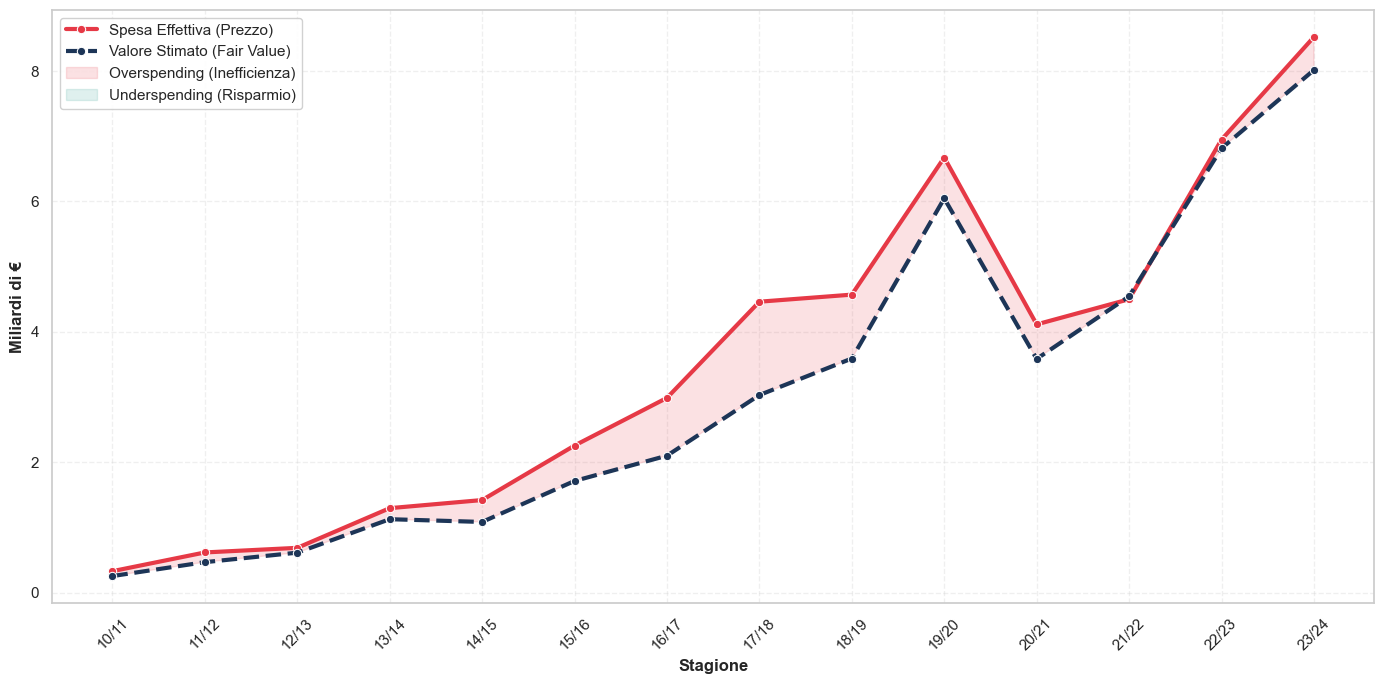

In [7]:
# print("[GRAFICO]: Grafico efficienza.")
plot_trend_efficienza(df_efficienza_full, CART_GRAFICI)


<div style="display: flex; align-items: center; justify-content: center; height: 100%;">
    <div style="width: 40%; text-align: left; margin-right: 30px;">
        <h2 style="color: #2c3e50; font-size: 45px; margin-bottom: 20px; line-height: 1.2;">
            5. L'Impatto dello Shock
        </h2>       
        <div style="font-size: 28px; color: #34495e; line-height: 1.4;">
            <p style="margin-bottom: 30px;">
                L'unico momento storico di <strong>"Underspending" (-1.0%)</strong> coincide con la crisi di liquidità del COVID.
            </p>        
            <div style="border-left: 5px solid #e74c3c; padding-left: 20px; background-color: #fdf2e9; padding: 15px;">
                <strong style="color: #c0392b;">Insight:</strong>
                <br>
                Solo uno shock esterno massivo ha costretto il mercato alla razionalità, eliminando il "premium price" speculativo.
            </div>
        </div>
    </div>
    <div style="width: 55%;">
        <img src="../Grafici/focus_area_verde_pure.png" 
             style="width: 100%; max-height: 80vh; object-fit: contain; box-shadow: none; background: white; border-radius: 8px;">
    </div>
</div>

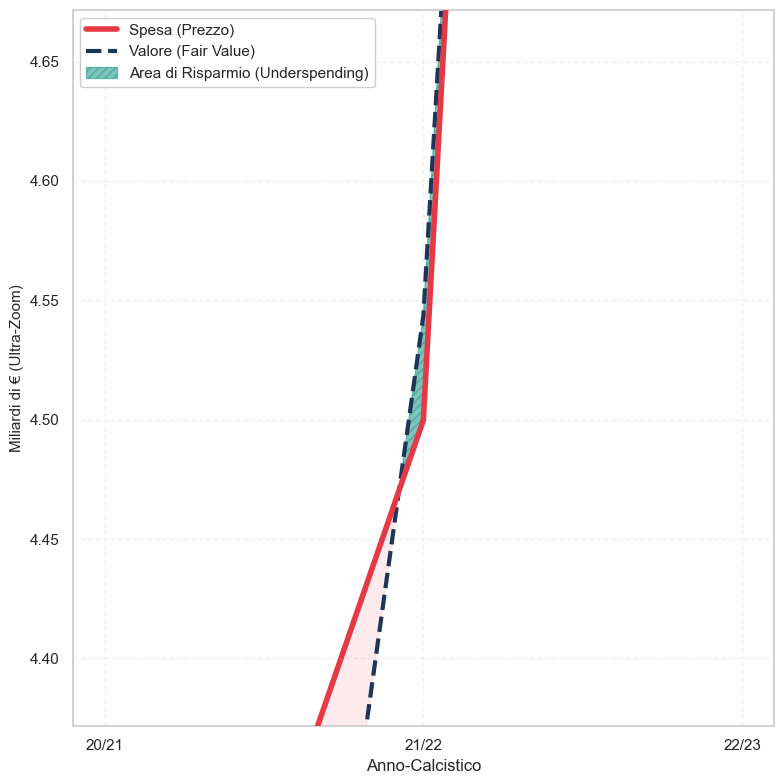

In [8]:
# print("[GRAFICO]: Grafico Area Verde Pura per anno calcistico 21/22.")
focus_AreaVerde(focusVerde(df_focus), CART_GRAFICI)
#skip

<div style="text-align: center; width: 100%;">
    <h2 style="color: #2c3e50; margin-bottom: 10px;">6. Il "Premium Price"</h2>
    <p style="font-size: 28px; color: #34495e; margin: 0;">
        I club pagano mediamente il <strong>21.5% in più</strong> del valore reale dei giocatori.
    </p>
</div>

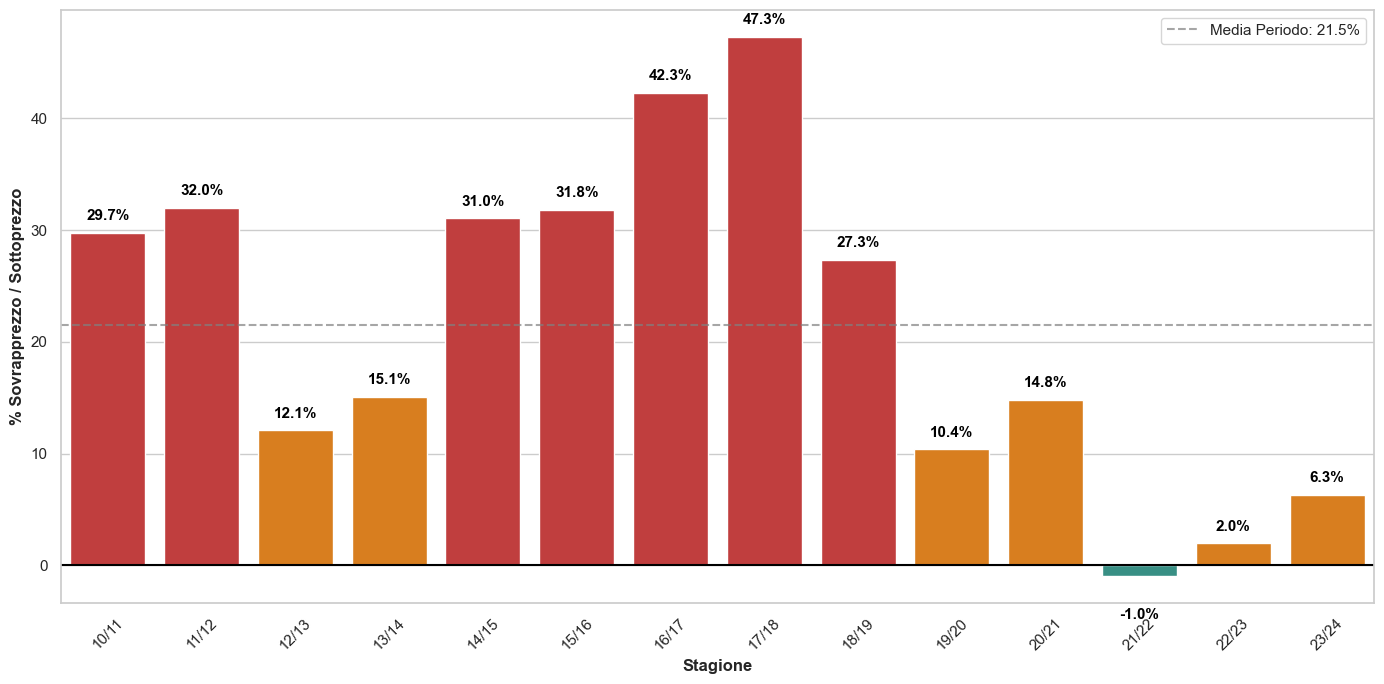

In [9]:
#print("[GRAFICO]: Grafico efficienza con percentuali.")
plot_premium_percentuale(df_efficienza_full, CART_GRAFICI)

#print("[DONE] Analisi completata.")

<div style="text-align: left; margin-top: 20px;">
    <h2 style="color: #2c3e50; font-size: 50px; margin-bottom: 30px; border-bottom: 3px solid #3498db; padding-bottom: 15px;">
        Conclusioni
    </h2>
    <div style="font-size: 26px; color: #34495e; line-height: 1.5;">
        <p style="margin-bottom: 25px;">In risposta alle domande poste in introduzione, l'analisi ha evidenziato:</p>
        <div style="margin-bottom: 30px;">
            <strong style="color: #2980b9; font-size: 30px; display: block; margin-bottom: 5px;">
                1. Risposta sull'Inflazione (Nominale vs Reale):
            </strong>
            L'ipotesi di crescita continua è stata confutata. Normalizzando i dati, si osserva che il <strong>potere d'acquisto reale del mercato è stagnante dal 2017</strong>. L'aumento della spesa nominale è attribuibile primariamente all'inflazione interna dei costi, non a un aumento del volume di talento.
        </div>
        <div style="margin-bottom: 30px;">
            <strong style="color: #2980b9; font-size: 30px; display: block; margin-bottom: 5px;">
                2. Risposta sulla Correlazione (Struttura):
            </strong>
            Esiste una correlazione lineare molto forte (<em>r</em> &approx; 0.95) in condizioni normali. Tuttavia, esiste un punto di rottura:
            <ul style="margin-top: 5px; margin-left: 40px;">
                <li>
                    <strong>L'Anomalia COVID (2020-2022):</strong> La correlazione si indebolisce. L'alto volume di scambi a fronte di una bassa spesa indica un cambiamento strutturale temporaneo (ricorso a prestiti/scambi) causato dalla crisi di liquidità.
                </li>
            </ul>
        </div>
        <div style="background-color: #ecf0f1; padding: 20px; border-left: 6px solid #2c3e50; border-radius: 5px; margin-top: 40px;">
            <strong style="color: #2c3e50; font-size: 28px; display: block; margin-bottom: 10px;">Sintesi:</strong>
            <span style="font-style: italic;">
                "Il mercato calcistico mostra una rigidità strutturale (alta correlazione) ma è altamente vulnerabile all'inflazione dei prezzi e agli shock di liquidità esogeni."
            </span>
        </div>
    </div>
</div>